In [1]:
import Pkg
Pkg.clone("https://github.com/mipt-npm/StatReg.jl.git")
using StatReg

┌ Warning: Pkg.clone is only kept for legacy CI script reasons, please use `add`
└ @ Pkg.API C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.1\Pkg\src\API.jl:391


  Updating registry at `C:\Users\user\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
  Updating git-repo `https://github.com/mipt-npm/StatReg.jl.git`


┌ Info: Path `C:\Users\user\.julia\dev\StatReg` exists and looks like the correct package, using existing path
└ @ Pkg.Types C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.1\Pkg\src\Types.jl:645


 Resolving package versions...
  Updating `C:\Users\user\.julia\environments\v1.1\Project.toml`
 [no changes]
  Updating `C:\Users\user\.julia\environments\v1.1\Manifest.toml`
 [no changes]


┌ Info: Precompiling StatReg [f8f957d0-a88d-11e9-060c-b1c5b748db97]
└ @ Base loading.jl:1186
┌ Warning: Package StatReg does not have Logging in its dependencies:
│ - If you have StatReg checked out for development and have
│   added Logging as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with StatReg
└ Loading Logging into StatReg from project dependency, future warnings for StatReg are suppressed.
Expr(:const, Symbol("##omega_memoized_cache") = Expr(:call, :IdDict))
  ** incremental compilation may be broken for this module **

Expr(:const, Symbol("##basis_functions_bernstein_memoized_cache") = Expr(:call, :IdDict))
  ** incremental compilation may be broken for this module **

Expr(:const, Symbol("##basis_function_bernstein_memoized_cache") = Expr(:call, :IdDict))
  ** incremental compilation may be broken for this module **

Expr(:const, Symbol("##derivative_memoized_cache") = Expr(

┌ Warning: Replacing docs for `StatReg.BaseFunction :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.Basis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.omega :: Tuple{StatReg.Basis,Int64}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.FourierBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.CubicSplineBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.LegendreBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223


┌ Warning: Replacing docs for `StatReg.BernsteinBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223


┌ Warning: Replacing docs for `StatReg.BaseFunction :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.Basis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.discretize_kernel :: Tuple{StatReg.Basis,Function,AbstractArray{#s14,1} where #s14<:Real}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.omega :: Tuple{StatReg.Basis,Int64}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.FourierBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.CubicSplineBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.LegendreBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.BernsteinBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223


┌ Warning: Replacing docs for `StatReg.BaseFunction :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.Basis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.omega :: Tuple{StatReg.Basis,Int64}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.FourierBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.CubicSplineBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.LegendreBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223


┌ Warning: Replacing docs for `StatReg.BernsteinBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.PhiVec :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223


┌ Warning: Replacing docs for `StatReg.BaseFunction :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.Basis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.discretize_kernel :: Tuple{StatReg.Basis,Function,AbstractArray{#s1381,1} where #s1381<:Real}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.omega :: Tuple{StatReg.Basis,Int64}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.FourierBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.CubicSplineBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.LegendreBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.BernsteinBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:22

┌ Warning: Replacing docs for `StatReg.BaseFunction :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.Basis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.discretize_kernel :: Tuple{StatReg.Basis,Function,AbstractArray{#s1381,1} where #s1381<:Real}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.omega :: Tuple{StatReg.Basis,Int64}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.FourierBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.CubicSplineBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.LegendreBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.BernsteinBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:22

┌ Warning: Replacing docs for `StatReg.PhiVec :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223


┌ Warning: Replacing docs for `StatReg.BaseFunction :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.Basis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.discretize_kernel :: Tuple{StatReg.Basis,Function,AbstractArray{#s1381,1} where #s1381<:Real}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.omega :: Tuple{StatReg.Basis,Int64}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.FourierBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.CubicSplineBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.LegendreBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.BernsteinBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:22

┌ Warning: Replacing docs for `StatReg.BaseFunction :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.Basis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.discretize_kernel :: Tuple{StatReg.Basis,Function,AbstractArray{#s1381,1} where #s1381<:Real}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.omega :: Tuple{StatReg.Basis,Int64}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.FourierBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.CubicSplineBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.LegendreBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223


┌ Warning: Replacing docs for `StatReg.BernsteinBasis :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.PhiVec :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.GaussErrorMatrixUnfolder :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.solve :: Tuple{StatReg.GaussErrorMatrixUnfolder,AbstractArray{#s1665,2} where #s1665<:Real,AbstractArray{#s1664,1} where #s1664<:Real,Union{AbstractArray{#s1663,1}, AbstractArray{#s1663,2}} where #s1663<:Real}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223
┌ Warning: Replacing docs for `StatReg.GaussErrorUnfolder :: Union{}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223


┌ Warning: Replacing docs for `StatReg.solve :: Union{Tuple{GaussErrorUnfolder,Union{Function, AbstractArray{#s1379,2} where #s1379<:Real},Union{Function, AbstractArray{#s213,1} where #s213<:Real},Union{Function, AbstractArray{#s45,1} where #s45<:Real}}, Tuple{GaussErrorUnfolder,Union{Function, AbstractArray{#s44,2} where #s44<:Real},Union{Function, AbstractArray{#s43,1} where #s43<:Real},Union{Function, AbstractArray{#s16,1} where #s16<:Real},Union{Nothing, AbstractArray{#s15,1} where #s15<:Real}}}` in module `StatReg`
└ @ Base.Docs docs\Docs.jl:223


Define target function $\varphi(x) = \frac{\sin(x)}{x}$ with support $[-20,20]$:

┌ Info: Recompiling stale cache file C:\Users\user\.julia\compiled\v1.1\Plots\ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184


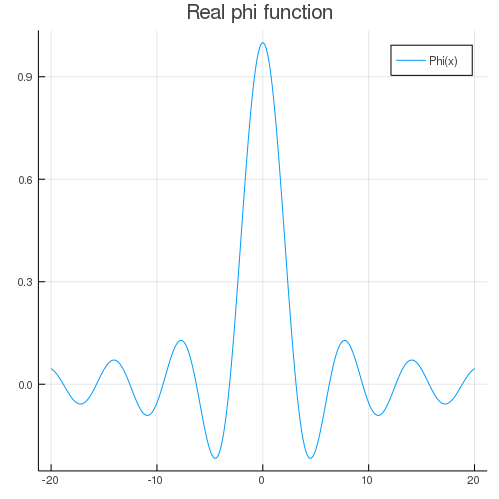

In [2]:
using Plots
plotly()
gr(size=(500,500), html_output_format=:png)

a = -20.
b = 20.

function phi(x::Real)
    if x != 0
        return sin(x)/x
    else
        return 1
    end
end

x = collect(range(a, stop=b, length=300))
myplot = plot(x, phi.(x), title="Real phi function",label=["Phi(x)"])

We will use diffraction kernel $K(x, y)$. $f(y)$ is an observed function, we need it to find the target function.

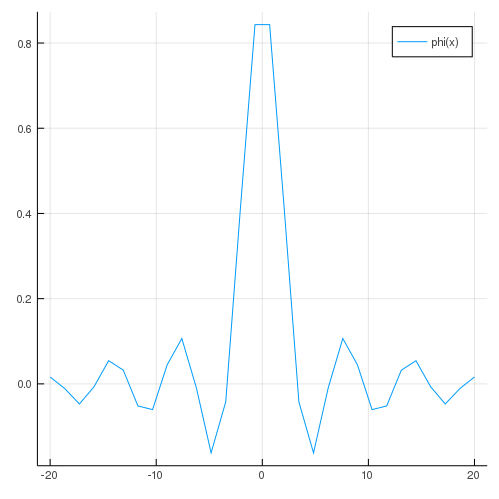

In [3]:
kernel(x::Real, y::Real) = getOpticsKernels("diffraction")(x, y)

using QuadGK
include("C:/Users/user/.julia/dev/StatReg/src/kernels.jl")
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]
y = collect(range(a, stop=b, length=30))
ftrue = convolution.(y)
myplot1 = plot(y, ftrue, label = "phi(x)")

Generation of noise (measurement errors):

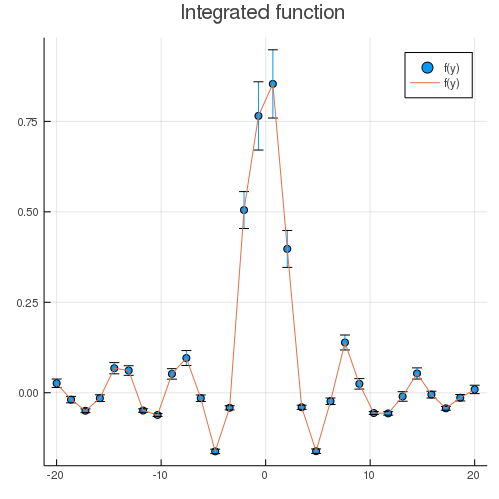

In [4]:
sig = ftrue*0.1 + [0.01 for i = 1:Base.length(ftrue)]

using Compat, Random, Distributions
noise = []
Random.seed!(1234)
for sigma in sig
    n = rand(Normal(0., abs(sigma)), 1)[1]
    push!(noise, n)
end

f = ftrue + noise
plot(y, f, title = "Integrated function", label = ["f(y)"], seriestype=:scatter, yerr=sig)
plot!(y, f, label = "f(y)")

We will use a Fourier Basis with 17 functions:

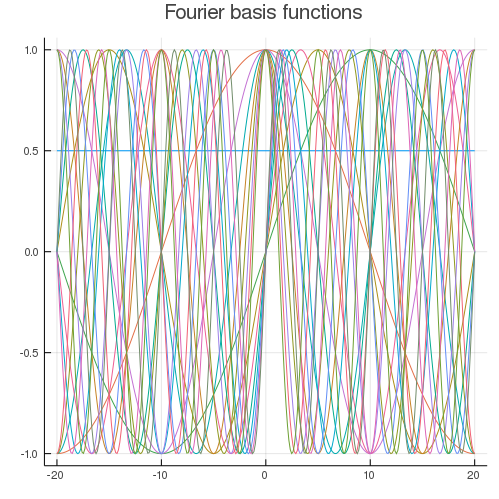

┌ Info: Fourier basis is created.
└ @ StatReg C:\Users\user\.julia\dev\StatReg\src\basis.jl:121


In [7]:
basis = FourierBasis(a, b, 8)
p = plot()
for func in basis.basis_functions
    p = plot!(x, func.f.(x), title="Fourier basis functions", legend=false, show = true)
end
display(p)

┌ Info: Calculating omega matrix for Fourier basis derivatives of order 2...
└ @ StatReg C:\Users\user\.julia\dev\StatReg\src\basis.jl:128


┌ Info: Omega caclulated successfully.
└ @ StatReg C:\Users\user\.julia\dev\StatReg\src\basis.jl:144
┌ Info: GaussErrorMatrixUnfolder is created
└ @ StatReg C:\Users\user\.julia\dev\StatReg\src\gauss_error.jl:66
┌ Info: GaussErrorUnfolder is created.
└ @ StatReg C:\Users\user\.julia\dev\StatReg\src\gauss_error.jl:170
┌ Info: Starting solve...
└ @ StatReg C:\Users\user\.julia\dev\StatReg\src\gauss_error.jl:203
┌ Info: Starting discretize kernel...
└ @ StatReg C:\Users\user\.julia\dev\StatReg\src\basis.jl:48
┌ Info: Kernel was discretized successfully.
└ @ StatReg C:\Users\user\.julia\dev\StatReg\src\basis.jl:59
┌ Info: Starting solve...
└ @ StatReg C:\Users\user\.julia\dev\StatReg\src\gauss_error.jl:96
┌ Info: Starting find_optimal_alpha...
└ @ StatReg C:\Users\user\.julia\dev\StatReg\src\check.jl:122


Iter     Function value   Gradient norm 


┌ Info: Starting optimization...
└ @ StatReg C:\Users\user\.julia\dev\StatReg\src\check.jl:147


     0     1.116709e+02     1.589367e+01
 * time: 0.016000032424926758
     1     5.873560e+01     1.295245e+01
 * time: 0.7249999046325684
     2     5.873281e+01     1.295187e+01
 * time: 0.7809998989105225
     3     5.873281e+01     3.564938e+08
 * time: 0.7850000858306885


┌ Info: Optimized successfully, alphas = [9.99986].
└ @ StatReg C:\Users\user\.julia\dev\StatReg\src\check.jl:162


┌ Info: Ending solve...
└ @ StatReg C:\Users\user\.julia\dev\StatReg\src\gauss_error.jl:114
┌ Info: Ending solve...
└ @ StatReg C:\Users\user\.julia\dev\StatReg\src\gauss_error.jl:211
┌ Info: PhiVec is created.
└ @ StatReg C:\Users\user\.julia\dev\StatReg\src\vector.jl:68


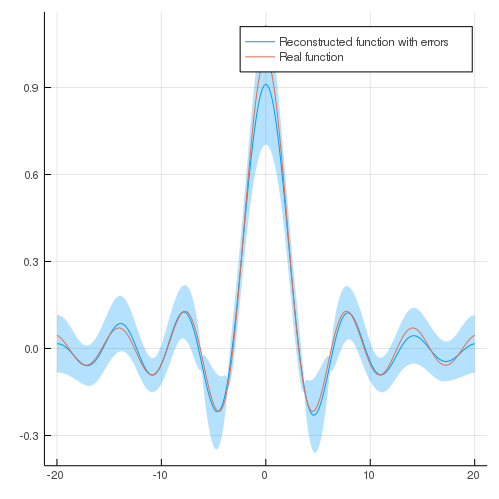

In [8]:
Omega = omega(basis, 2)
model = GaussErrorUnfolder(basis, [Omega], "EmpiricalBayes", nothing, [1e-8], [10.], [0.3])
println()

result = solve(model, kernel, f, sig, y)
println()

phivec = PhiVec(result, basis)

phi_reconstructed = phivec.phi_function.(x)
phi_reconstructed_errors = phivec.error_function.(x)

plot(x, phi_reconstructed, ribbon=phi_reconstructed_errors, fillalpha=0.3, label="Reconstructed function with errors")
plot!(x, phi.(x), label="Real function")